In [5]:
import torch
import torchvision as tv
import torch.nn as nn
import tqdm
import os
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np


In [3]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)
        
        return out

class MyResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(MyResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)


        self.layer1 = self._make_layer(64, 3)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(512 * Bottleneck.expansion, 1024)
        self.dropout = nn.Dropout(p=0.3) 
        self.fc2 = nn.Linear(1024, num_classes)  
        
    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * Bottleneck.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * Bottleneck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * Bottleneck.expansion),
            )

        layers = []
        layers.append(Bottleneck(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * Bottleneck.expansion
        
        for _ in range(1, blocks):
            layers.append(Bottleneck(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x) 
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x) 
        
        return x

In [6]:

import csv
import random
DATASET_DIR = "dataset"
OUTPUT_CSV = "car_colors_dataset.csv"
TRAIN_RATIO = 0.8 
def merge_similar_colors(data):
    color_mapping = {
        "Dark Blue": {"Indigo", "Navy"},
        "Dark Red": {"Burgundy", "Maroon"},
        "Pink": {"Magenta", "Pink"},
        "Beige/Brown": {"Beige", "Brown"},
        "Multicolour": {"Multicolour", "Unlisted"},
    }

    def map_color(color):
        for new_color, old_colors in color_mapping.items():
            if color in old_colors:
                return new_color
        return color

    merged_data = [(filepath, map_color(color)) for filepath, color in data]

    unique_colors = set(c for _, c in merged_data)
    print(f"осталось классов: {unique_colors}")
    return merged_data

def extract_color(filename):
    parts = filename.split("$$")
    if len(parts) < 4:
        print(f"Пропущен файл: {filename}")
        return None 
    color = parts[3]
    return color

def collect_data(dataset_dir):
    data = []

    for model in os.listdir(dataset_dir):
        model_path = os.path.join(dataset_dir, model)
        if not os.path.isdir(model_path):
            print(f"Пропущен файл {model_path}")
            continue

        for year in os.listdir(model_path):
            year_path = os.path.join(model_path, year)
            if not os.path.isdir(year_path):
                print(f"Пропущен файл {year_path}")
                continue


            for filename in os.listdir(year_path):
                if filename.endswith((".jpg", ".png", ".jpeg")):
                    color = extract_color(filename)
                    if color:
                        relative_path = os.path.join(model, year, filename)
                        data.append((relative_path, color))
                else:
                    print(f"Пропущен файл {filename}")

    print(f"собрано {len(data)} изображений")
    return data

def split_and_save(data, output_csv, train_ratio=0.8):
    random.shuffle(data)
    split_idx = int(len(data) * train_ratio)
    train_data, test_data = data[:split_idx], data[split_idx:]

    with open(output_csv, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["filepath", "color", "split"])

        for row in train_data:
            writer.writerow([row[0], row[1], "train"])
        for row in test_data:
            writer.writerow([row[0], row[1], "test"])



data = collect_data(DATASET_DIR)
data = merge_similar_colors(data)
split_and_save(data, OUTPUT_CSV, TRAIN_RATIO)




собрано 61827 изображений
осталось классов: {'Grey', 'Bronze', 'Green', 'White', 'Purple', 'Pink', 'Black', 'Gold', 'Red', 'Dark Blue', 'Orange', 'Silver', 'Turquoise', 'Multicolour', 'Beige/Brown', 'Blue', 'Dark Red', 'Yellow'}


In [7]:
from collections import Counter
def balance_dataset(data, min_samples=2000, max_samples=5000):
    balanced_data = []
    class_counts = Counter([color for _, color in data])

    for color, count in class_counts.items():
        filtered_data = [item for item in data if item[1] == color]

        if count < min_samples:
            factor = min_samples // count
            balanced_data.extend(filtered_data * factor)
        elif count > max_samples:
            balanced_data.extend(filtered_data[:max_samples])
        else:
            balanced_data.extend(filtered_data)

    random.shuffle(balanced_data)
    print(f"После балансировки: {len(balanced_data)}")

data = balance_dataset(data)
split_and_save(data, OUTPUT_CSV)


После балансировки: 51416


In [5]:


BATCH_SIZE = 128
EPOCHS = 100
LEARNING_RATE = 0.001
TRAIN_CSV = "car_colors_dataset.csv"
DATASET_DIR = "dataset"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOG_FILE = "training_log.txt"


In [6]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience

In [23]:

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt


class CarColorDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, split="train"):
        self.data = pd.read_csv(csv_file)
        self.data = self.data[self.data["split"] == split]
        self.root_dir = root_dir
        self.transform = transform

        self.classes = sorted(self.data["color"].unique())
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        print(f"Dataset {split}: {len(self.data)} images, Classes: {self.classes}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label = self.class_to_idx[self.data.iloc[idx, 1]]

        if self.transform:
            image = self.transform(image)

        return image, label
    
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = CarColorDataset(TRAIN_CSV, DATASET_DIR, transform, "train")
test_dataset = CarColorDataset(TRAIN_CSV, DATASET_DIR, transform, "test")
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

def train_model(model, train_loader, test_loader, criterion, optimizer, epochs, patience=7):
    history = {"train_loss": [], "val_loss": [], "val_f1": []}
    early_stopping = EarlyStopping(patience=patience)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            if batch_idx % 500 == 0:
                print(f"Эпоха [{epoch+1}/{epochs}], Батч [{batch_idx}/{len(train_loader)}], Потеря: {loss.item():.4f}")
        avg_train_loss = running_loss / len(train_loader)
        val_loss, val_f1 = evaluate_model(model, test_loader, criterion)
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(val_loss)
        history["val_f1"].append(val_f1)
        print(f"Эпоха {epoch+1} закончга Итог на трейне {avg_train_loss:.4f}, Итог на валидации {val_loss:.4f}, F1: {val_f1:.4f}")
        scheduler.step(val_loss)
        if early_stopping.step(val_loss):
                print(f"Стоп  обучения на эпохе {epoch+1} (без улучшений {patience} эпох)")
                break
       
    
    return history


def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    f1 = f1_score(all_labels, all_preds, average="macro")
    return avg_loss, f1




Dataset train: 41132 images, Classes: ['Beige/Brown', 'Black', 'Blue', 'Bronze', 'Dark Blue', 'Dark Red', 'Gold', 'Green', 'Grey', 'Multicolour', 'Orange', 'Pink', 'Purple', 'Red', 'Silver', 'Turquoise', 'White', 'Yellow']
Dataset test: 10284 images, Classes: ['Beige/Brown', 'Black', 'Blue', 'Bronze', 'Dark Blue', 'Dark Red', 'Gold', 'Green', 'Grey', 'Multicolour', 'Orange', 'Pink', 'Purple', 'Red', 'Silver', 'Turquoise', 'White', 'Yellow']


In [16]:

model = MyResNet(num_classes=len(train_dataset.classes)).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
early_stopping_patience = 5 


history = train_model(model, train_loader, test_loader, criterion, optimizer, EPOCHS)

Start
Эпоха [1/100], Батч [0/1286], Потеря: 2.9375
Эпоха [1/100], Батч [500/1286], Потеря: 1.8731
Эпоха [1/100], Батч [1000/1286], Потеря: 1.6631
Эпоха 1 закончга Итог на трейне 1.9014, Итог на валидации 1.7542, F1: 0.2822
Эпоха [2/100], Батч [0/1286], Потеря: 1.7897
Эпоха [2/100], Батч [500/1286], Потеря: 1.6071
Эпоха [2/100], Батч [1000/1286], Потеря: 1.5034
Эпоха 2 закончга Итог на трейне 1.3995, Итог на валидации 1.2719, F1: 0.5067
Эпоха [3/100], Батч [0/1286], Потеря: 1.4132
Эпоха [3/100], Батч [500/1286], Потеря: 0.9702
Эпоха [3/100], Батч [1000/1286], Потеря: 0.8749
Эпоха 3 закончга Итог на трейне 1.1387, Итог на валидации 1.0163, F1: 0.6170
Эпоха [4/100], Батч [0/1286], Потеря: 0.9627
Эпоха [4/100], Батч [500/1286], Потеря: 1.1721
Эпоха [4/100], Батч [1000/1286], Потеря: 0.9017
Эпоха 4 закончга Итог на трейне 0.9830, Итог на валидации 1.0827, F1: 0.6061
Эпоха [5/100], Батч [0/1286], Потеря: 0.8570
Эпоха [5/100], Батч [500/1286], Потеря: 0.9511
Эпоха [5/100], Батч [1000/1286], П

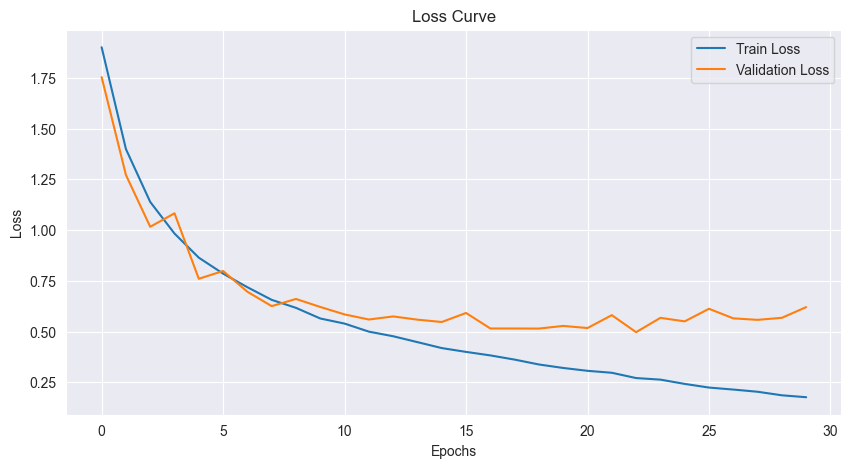

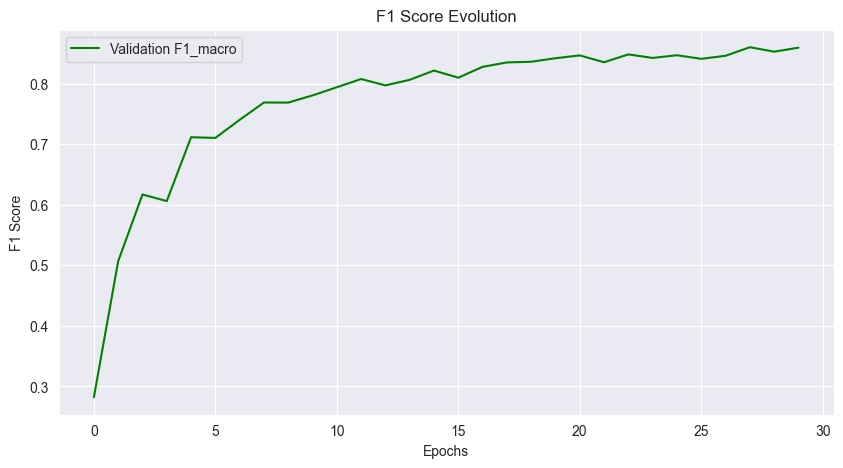

In [17]:


plt.figure(figsize=(10, 5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history["val_f1"], label="Validation F1_macro", color="green")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend()
plt.title("F1 Score Evolution")
plt.show()


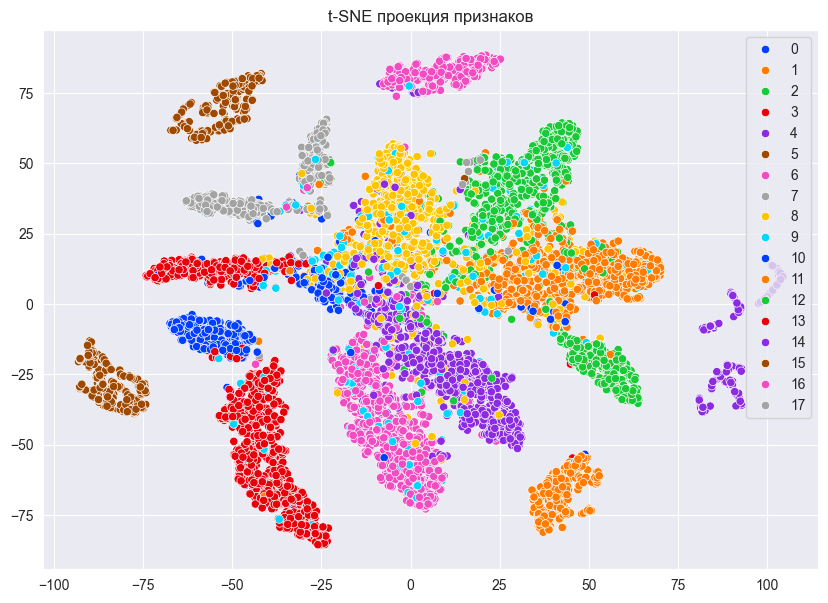

In [20]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import f1_score
from sklearn.manifold import TSNE
from PIL import Image
import os
def visualize_tsne(model, dataloader):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for images, label in dataloader:
            images = images.to(DEVICE)
            output = model(images)
            features.append(output.cpu().numpy())
            labels.append(label.numpy())
    
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced_features = tsne.fit_transform(features)
    
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=labels, palette="bright", legend=True)
    plt.title("t-SNE проекция признаков")
    plt.show()
    
visualize_tsne(model, test_loader)


In [20]:
import torchvision.models as models
num_classes = len(train_dataset.classes)

resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.BatchNorm1d(512), 
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, num_classes)
)

for param in resnet50.parameters():
    param.requires_grad = False
    
for param in resnet50.layer3.parameters():
    param.requires_grad = True

for param in resnet50.fc.parameters():
    param.requires_grad = True  

resnet50 = resnet50.to(DEVICE)
print(resnet50)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(resnet50.fc.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

history2 = train_model(resnet50, train_loader, test_loader, criterion, optimizer, EPOCHS)


Эпоха [1/100], Батч [0/322], Потеря: 1.5784
Эпоха 1 закончга Итог на трейне 1.3474, Итог на валидации 1.2262, F1: 0.5953
Эпоха [2/100], Батч [0/322], Потеря: 1.3150
Эпоха 2 закончга Итог на трейне 1.2190, Итог на валидации 1.1474, F1: 0.6204
Эпоха [3/100], Батч [0/322], Потеря: 1.2747
Эпоха 3 закончга Итог на трейне 1.1448, Итог на валидации 1.1074, F1: 0.6284
Эпоха [4/100], Батч [0/322], Потеря: 1.3902
Эпоха 4 закончга Итог на трейне 1.0979, Итог на валидации 1.0736, F1: 0.6381
Эпоха [5/100], Батч [0/322], Потеря: 1.0971
Эпоха 5 закончга Итог на трейне 1.0659, Итог на валидации 1.0369, F1: 0.6409
Эпоха [6/100], Батч [0/322], Потеря: 1.2812
Эпоха 6 закончга Итог на трейне 1.0334, Итог на валидации 1.0231, F1: 0.6396
Эпоха [7/100], Батч [0/322], Потеря: 1.1699
Эпоха 7 закончга Итог на трейне 1.0057, Итог на валидации 0.9971, F1: 0.6601
Эпоха [8/100], Батч [0/322], Потеря: 0.8711
Эпоха 8 закончга Итог на трейне 0.9875, Итог на валидации 0.9874, F1: 0.6624
Эпоха [9/100], Батч [0/322], Пот

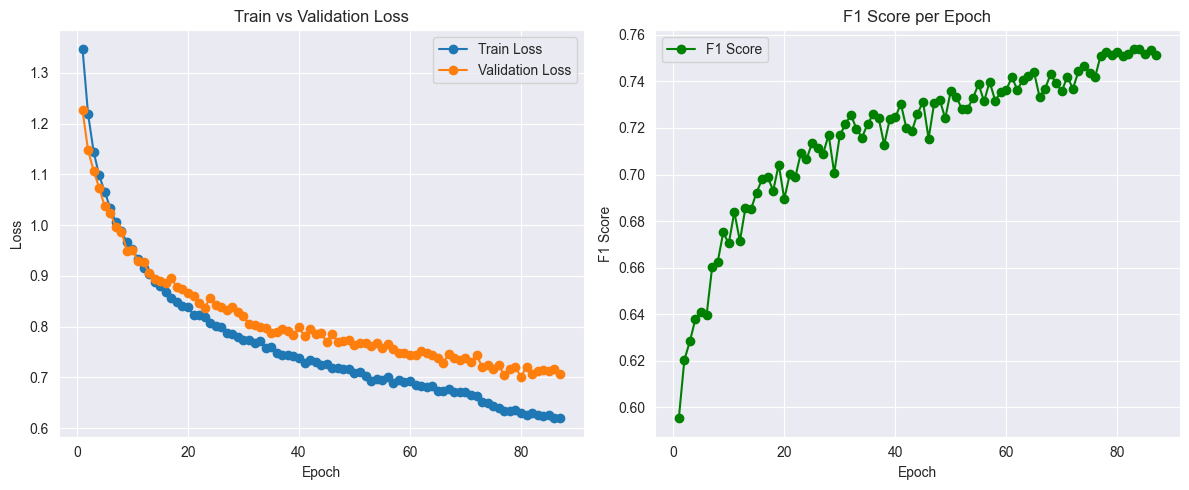

In [2]:


plt.figure(figsize=(10, 5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 5))
plt.plot(history["val_f1"], label="Validation F1_macro", color="green")
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [56]:
print(train_dataset.data["color"].value_counts())

color
Red            4031
Blue           4025
Black          4011
White          3999
Silver         3985
Grey           3973
Dark Red       1622
Dark Blue      1595
Turquoise      1585
Bronze         1574
Gold           1549
Pink           1522
Purple         1430
Multicolour    1356
Orange         1335
Green          1252
Beige/Brown    1210
Yellow         1078
Name: count, dtype: int64
